In [50]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from ae import AutoEncoder
import torch
from torchvision.transforms import transforms
%reload_ext autoreload
%autoreload 2


In [2]:
def load_image_as_np(image_path):
    return np.asarray(Image.open(image_path).convert('RGB'), dtype=np.uint8)

def store_image_from_np(image_path,data,format='RGB'):
    img = Image.fromarray(data, format)
    img.save(image_path)
    return img

In [76]:
def segment_image(image,tile_size,pad_type='reflect'):
    img_height,img_width = image.shape[:2]

    # Pads the image so it can be chunked down to a grid even if the size of the image is not
    # divisible by the chunk size
    v_pad = (0,tile_size - (img_height % tile_size)) if img_height % tile_size != 0 else (0,0)
    h_pad = (0,tile_size - (img_width % tile_size)) if img_width % tile_size != 0 else (0,0)
        
    image = np.pad(image, (v_pad,h_pad,(0,0)), pad_type)

    img_height , img_width, channels = image.shape

    tiled_array =  image.reshape(img_height // tile_size,
                                 tile_size,
                                 img_width // tile_size,
                                 tile_size,
                                 channels)

    tiled_array = tiled_array.swapaxes(1,2)

    return np.concatenate(tiled_array,axis=0)


In [92]:
def rebuild_image(tile_array,image_size,tile_size):
    img_height, img_width, channels = image_size
    
    tile_rows = int(np.ceil(img_height/tile_size))
    tile_cols = int(np.ceil(img_width/tile_size))

    tile_array = tile_array.reshape(tile_rows,
                                    tile_cols,
                                    tile_size,
                                    tile_size,
                                    channels)
    
    tile_array = np.concatenate(tile_array,axis=1)
    tile_array = np.concatenate(tile_array,axis=1)

    return tile_array[:img_height,:img_width]

In [87]:
def get_model(model_path):
    model = AutoEncoder.load_autoencoder(model_path)
    return send_to_device(model)


def send_to_device(pytorch_object):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pytorch_object = pytorch_object.to(device)
    return pytorch_object


def apply_compress_function(tile_tensor, model_path):
    model = get_model(model_path)
    return model.encode(send_to_device(tile_tensor))

def apply_decompression_function(encoded_tile_tensor,model_path) :
    model = get_model(model_path)
    return model.decode(encoded_tile_tensor)    

In [132]:
def make_tensor(tile_list_array):
    tile_list_array = tile_list_array.reshape(tile_list_array.shape[0],3*8*8)
    transform = transforms.ToTensor()
    tile_tensor = transform(tile_list_array)
    return tile_tensor

def retrieve_array(decoded_tile_tensor):
    res = decoded_tile_tensor.detach().cpu().view(-1,3,8,8).numpy()
    return res

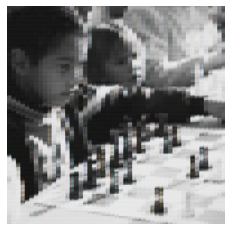

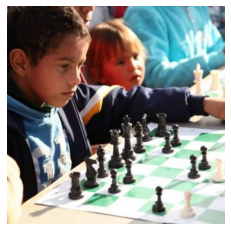

In [131]:
wd_path = os.path.abspath(os.getcwd())
models_path = os.path.join(wd_path, "models")
model_used_path = os.path.join(models_path, "ae_0.pt")
image_path = os.path.join(wd_path,"images","Niños_jugando_al_ajedrez-390x390.jpg")
image_path_out = os.path.join(wd_path,"images","tenemos_out.jpeg")
tile_size= 8

test_image                  = load_image_as_np(image_path)
tile_list                   = segment_image(test_image,tile_size=8,pad_type='reflect')

tile_tensor                 = make_tensor(tile_list)
compressed_image_tensor     = apply_compress_function(tile_tensor,model_used_path)
decompressed_image_tensor   = apply_decompression_function(compressed_image_tensor,model_used_path)
decompresssed_image         = retrieve_array(decompressed_image_tensor)

end_image                   = rebuild_image(decompresssed_image,test_image.shape,tile_size)

plt.imshow(end_image)
plt.axis('off')
plt.show()
plt.imshow(test_image.astype('uint8'))
plt.axis('off')
plt.show()